# Randomized A/B Testing 
## by Sooyeon Won

## Table of Contents
- [Introduction](#intro)
- [Data Preparation](#preparation)
- [Data Exploration: Part I - Probability Comparison](#probability)
- [Data Exploration: Part II - A/B Test](#ab_test)
- [Data Exploration: Part III - Regression Analysis](#regression)
- [Conclusion](#conclusion)

<a id='intro'></a>
## Introduction

> A/B tests are commonly performed in various industries. A/B testing is simple, but crucial for all businesses who want to test out their new scenarios. The results from A/B tests provide statistically significant results, simply by setting up a test and comparing the results against the control. <br><br>
In this analysis, I investigate the data obtained from a company in e-commerce industry, and explain the results of the A/B test run by an e-commerce website. This company has developed a new design of its web page, in order to try and increase the number of users who "convert". The converted users mean the users who pay for the company's products. 
Based on the statistical facts and the findings from A/B Testing, this analysis will provide recommendations whether the company should implement the new page, keep the old page, or perhaps run the experiment longer to make its decision.



<a id='preparation'></a>
## Data Preparation

In [1]:
# Start the analysis with importing relevant libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

In [2]:
ab_df = pd.read_csv('ab_data.csv') # Read the csv file and store it as ab_df
ab_df.head() # Take a look at few rows in the data

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
ab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [4]:
ab_df.isnull().sum() # Check missing values in each column

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

> - Almost 300,000 datapoints are collected and all features do not contain missing values. 
> - The datatype of the following columns should be changed.
    1. "user_id" is not a numeric variable. It should be an "object". 
    2. "timestamp" should have the datatype of "datetime". 
    3. "converted" is a categorical variable. It should be an "object", but for the convienece of computation, I kept the original datatype.  

In [5]:
ab_df['user_id']=ab_df['user_id'].astype(str)
ab_df['timestamp'] = pd.to_datetime(ab_df['timestamp'])

In [6]:
print('The earliest date of datapoints: ', ab_df['timestamp'].min())
print('The latest date of datapoints: ', ab_df['timestamp'].max())
print('Total numbere of datapoints: ', ab_df.shape[0])
# 294,478 datapoints are gathered from 2017-01-02 to 2017-01-24.

The earliest date of datapoints:  2017-01-02 13:42:05.378582
The latest date of datapoints:  2017-01-24 13:41:54.460509
Total numbere of datapoints:  294478


<a id='probability'></a>
## Data Exploration 
### Part I - Probability

#### 1. The number of unique users

In [7]:
unique_users = len(ab_df.user_id.unique())
print ('The dataset has', unique_users, 'unique users.') 

The dataset has 290584 unique users.


#### 2. The proportion of users converted

In [8]:
conversion_all = ab_df.converted.mean()*100
print ('The percentage of users coverted in the dataset is ', '{:.2f}'.format(conversion_all), '%.' )

The percentage of users coverted in the dataset is  11.97 %.


#### 3. The number of user-ids the `new_page` and `treatment` don't match up

In [9]:
ab_df.group.value_counts()

treatment    147276
control      147202
Name: group, dtype: int64

In [10]:
ab_df.landing_page.value_counts()

new_page    147239
old_page    147239
Name: landing_page, dtype: int64

> The new/old design of webpage are exclusively landed to the users in the treatment/control group, respectively. However, the number of datapoints in treatment/control group in the dataset does not match up with the number of datapoints in 'new_page','old_page', vice versa. So, I check the total number of unmatched datapoints in the dataset. 

In [11]:
old_treatment = ab_df.query('group == "treatment" and landing_page == "old_page"').nunique()
new_control= ab_df.query('group == "control" and landing_page == "new_page"').nunique()
unmatched =  old_treatment + new_control
print('There are', old_treatment[0], 'unique users in treatment group matched with old design page.')
print('There are', new_control[0], 'unique users in control group matched with new design page.')
print('In total,', unmatched[0] , 'unique users are unmatched.')

There are 1965 unique users in treatment group matched with old design page.
There are 1928 unique users in control group matched with new design page.
In total, 3893 unique users are unmatched.


> There are some datapoints where **treatment** is not aligned with **new_page**, or **control** is not aligned with **old_page**. Without additional information, we can not be sure whether they received the new or old page, such rows are dropped.

In [12]:
indexNames = ab_df[ (ab_df.group == 'treatment')!=(ab_df.landing_page == 'new_page')].index
ab_mod=ab_df.drop(indexNames) # The modified dataset is renamed as ab_mod.

In [13]:
# Double Check all of the correct rows were removed. 
ab_mod[((ab_mod['group'] == 'treatment') == (ab_mod['landing_page'] == 'new_page')) == False].shape[0]

0

#### 4. The number of unique users in the modified dataset

In [14]:
user_num=ab_mod.shape
print ('After the unmatched datapoints are dropped, there are', user_num[0], 'user-ids in the dataset.') 

After the unmatched datapoints are dropped, there are 290585 user-ids in the dataset.


In [15]:
user_unique=ab_mod.user_id.nunique()
print ('Now, we have', unique_users, 'number of unique users.') 

Now, we have 290584 number of unique users.


In [16]:
sum(ab_mod.user_id.duplicated()) # This means, there is one repeated user_id in the modified dataset.

1

In [17]:
# Which user-id is duplicated? 
duplicated_row = ab_mod[ab_mod.duplicated(['user_id'])] 
print(duplicated_row)

     user_id                  timestamp      group landing_page  converted
2893  773192 2017-01-14 02:55:59.590927  treatment     new_page          0


In [18]:
ab_df.query('user_id == "773192"')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


> The repeated user_id is '773192'. The user visited the website twice during the experiment period. <br> 
Thus, the latest datapoint is dropped.

In [19]:
ab_mod.drop_duplicates(subset=['user_id'], inplace = True)

In [20]:
ab_mod.query('user_id == "773192"') # Recheck whether the duplicated user-id is removed.

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


> After unmatched samples and duplicates are dropped, we have 290,584 unique users in the modified dataset.

#### 5. Randomly selected treatment and control units 

> The treatment and control units are completely randomly chosen. In this part, I compare other characteristics of the groups. Based on the timestape information, I plot the number of unique users in each weekday, day, and hour. As the following plots show, the patterns of web page visits are very similar in both units. This implies that the only difference between the two groups are nothing but the landing page. 

In [21]:
import datetime as dt
import seaborn as sns
ab_copy = ab_mod.copy()
ab_copy['weekday'] = ab_copy.timestamp.dt.day_name()
ab_copy['hour'] = ab_copy.timestamp.dt.hour
ab_copy['day'] = ab_copy.timestamp.dt.day

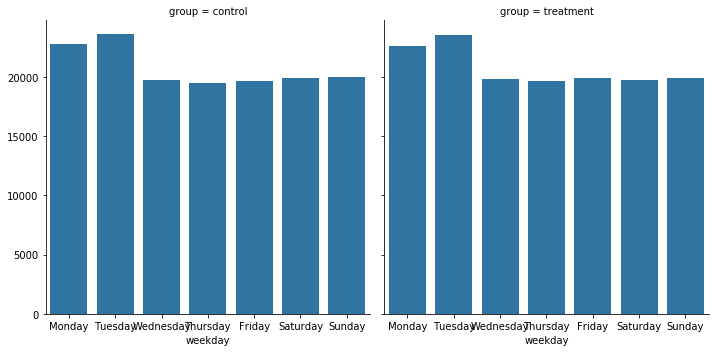

In [22]:
g = sns.FacetGrid(data = ab_copy, col='group', height=5)
weekday_ord=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
g = g.map(sns.countplot, "weekday", order = weekday_ord );
g.add_legend()
plt.show()

C:\Users\wonso\anaconda3\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


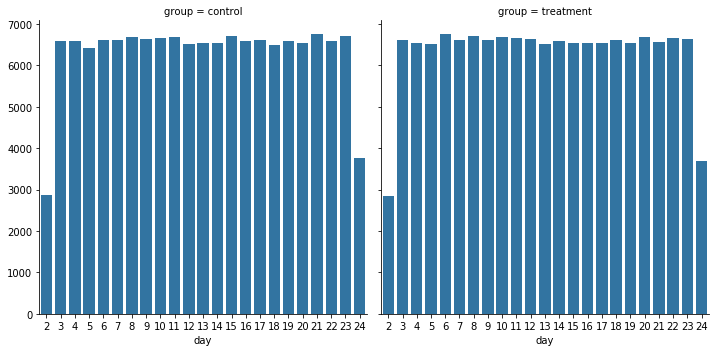

In [23]:
g = sns.FacetGrid(data = ab_copy, col='group', height=5)
g = g.map(sns.countplot, "day");
g.add_legend()
plt.show()

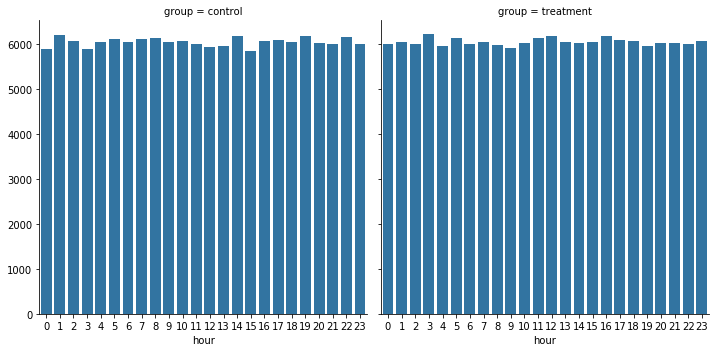

In [24]:
g = sns.FacetGrid(data = ab_copy, col='group', height=5)
g = g.map(sns.countplot, "hour");
g.add_legend()
plt.show()

#### 6. The probability of an individual converting 

##### 6-1. Overall conversion rate (regardless of landing pages)

In [25]:
conversion_all = ab_mod.converted.mean()
print ('The proportion of users coverted in the dataset is', '{:.4f}'.format(conversion_all), '.' )

The proportion of users coverted in the dataset is 0.1196 .


##### 6-2. The conversion rate given that an individual was in the `control` group

In [26]:
df_control = ab_mod.query('group == "control"')
conversion_control = df_control.converted.mean()
print ('The user conversion rate, given that an individual was in control group is', '{:.4f}'.format(conversion_control), '.' )

The user conversion rate, given that an individual was in control group is 0.1204 .


##### 6-3. The conversion probability given that an individual was in the `treatment` group

In [27]:
df_treatment = ab_mod.query('group == "treatment"')
conversion_treatment = df_treatment.converted.mean()
print ('The user conversion rate, given that an individual was in treatment group is', '{:.4f}'.format(conversion_treatment), '.' )

The user conversion rate, given that an individual was in treatment group is 0.1188 .


##### 6-4. The probability that an individual received the new page

In [28]:
num_newpage = ab_mod.query('landing_page == "new_page"')['user_id'].count()
num_all = ab_mod.user_id.count()
print ('The probability of receiving the new page for an individual is', '{:.4f}'.format(num_newpage/num_all), '.' )

The probability of receiving the new page for an individual is 0.5001 .


> **Findings**: The overall conversion rate is 11.96%. The conversion rate given control, treatment group in the dataset is 12.04%, 11.88%, respectively. The control group showed a higher conversion rate by 0.16%, comparing to the treatment group. The average conversion rates in each group does not provide enough evidence that the new treatment page lead to more conversions. Also, the difference is very small. The difference could be occurred simply due to sampling error. To make sure the difference is statistcally significant, I performed several statistcal testings. Additionally, the result from _6-4_ indicates that the size of both groups are well-balanced. 

<a id='ab_test'></a>
### Part II - A/B Test

> To perform A/B Testing, deciding the proper duration of test is one of the crucial considerations. Because each event is recorded with its timestamp, we could run hypothesis tests continuously as each datapoint is collected. It would be "technically" possible that we stop as soon as one page is considered significantly better than another. Whether the test needs to happen consistently for a certain amount of time or How long a company run the test to render a decision that neither page is better than another could be hugh issues. Test duration is generally one of difficult parts associated with A/B tests. <br><br>
For now, I simply considered all the provided data **only**, to drive the decision. <br>
To begin with, I assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%. <br>
The null($H_0$) and alternative($H_1$) hypotheses are denoted as follows. <br> **$p_{old}$** and **$p_{new}$** mean the converted rates for the old and new pages, respectively.

$$H_0: p_{old} - p_{new}  \geq 0$$


$$H_1: p_{old} - p_{new} < 0$$



> In words, the null($H_0$) hypothesis indicates that the conversion rate for old pages is better than or "at least" equal to the conversion rate for new pages. The alternative($H_1$) hypothesis, on the other hand, indicates the conversion rate for new pages is better than that the converted rate for the old pages. 

> I supposed that under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page. (i.e. $p_{new}$ =  $p_{old}$). Since users are randomly assigned to the treatment and control groups, this assumption makes sense. Likewise, I assumed that they are equal to the **converted** rate in my dataset regardless of the page. <br><br>
Then using a sample size for each page equal to the ones in my dataset, I performed the sampling distribution for the difference in **converted** rate between the two pages over 10,000 iterations of calculating an estimate from the null. The following cells below provide the steps of this simulation.  

#### 1. **Convert rate** for $p_{new}$ and $p_{old}$ under the null hypothesis

In [29]:
p_new = ab_mod.converted.mean()
p_old = ab_mod.converted.mean() 
print ('The converted rate for new landing page is', '{:.4f}'.format(p_new), '.' )
print ('The converted rate for old landing page is', '{:.4f}'.format(p_old), '.' )

The converted rate for new landing page is 0.1196 .
The converted rate for old landing page is 0.1196 .


#### 2. **Sample size** for new_page($n_{new}$),  old_page($n_{old}$)

In [30]:
ab_mod.landing_page.value_counts()

new_page    145310
old_page    145274
Name: landing_page, dtype: int64

In [31]:
n_new = ab_mod.landing_page.value_counts()[0] # Sample size for new_page
n_old = ab_mod.landing_page.value_counts()[1] # Sample size for old_page

> Under the null hypothesis, I assumed that the conversion rate for the treatment and control is equivalent to the overall conversion rate in our actual data. Thus, the conversion rate for both $p_{new}$ and $p_{old}$  is equal to 0.1196. 
Also, I simulated data for each group based on binomial distribution with the same size of the treatment and control groups in the dataset.

#### 3. **Simulation** of $n_{new}$ times transactions with a convert rate of $p_{new}$ under the null.  

> These $n_{new}$ 1's (which mean "converted") and 0's (which mean "not converted") are stored in  "new_page_converted". Same procedure is conducted for old_page.

In [32]:
new_page_converted = np.random.binomial(1, p_new, n_new) 
old_page_converted = np.random.binomial(1, p_old, n_old) 

#### 4. **Difference** of the simulated values (i.e. $p_{new}$ - $p_{old}$ ) 

In [33]:
simulation_diff = new_page_converted.mean() - old_page_converted.mean()

print ('The simulated difference is : ', simulation_diff)

The simulated difference is :  -0.002032281748372708


> The difference is very trivial and also close to zero. The difference could be significant, but also occured due to sampling errors. Therefore, I simulate 10,000 values of the difference and plot its distribution. 

#### 5. **Simulation** of 10,000 times the difference values ($p_{new}$ - $p_{old}$) 

> The simulated values are stored in a numpy array called **p_diffs**.

In [34]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.binomial(1, p_new, n_new) 
    old_page_converted = np.random.binomial(1, p_old, n_old) 
    differences = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(differences)


In [35]:
p_diffs = np.array(p_diffs) # The list format is changed to an array format.
p_diffs

array([ 0.00118842, -0.00098636, -0.00200508, ..., -0.00075237,
        0.00054166,  0.00091335])

#### 6. Distribution of p_diffs

> As Central Limit Theorem says, in a large sample size, the sample means follow a normal distribution. As expected, the p_diffs plot shows the bell-shaped normal distribution. Additionally, I added a blue line, indicating the actual difference of our sample statistics.

In [36]:
actual_diff = conversion_treatment - conversion_control 
print('Actual difference (sample statistic): ', actual_diff)

Actual difference (sample statistic):  -0.0015782389853555567


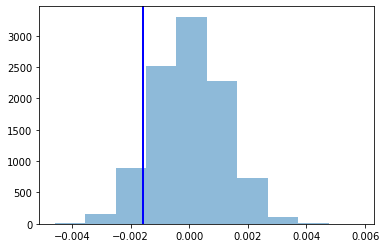

In [37]:
plt.hist(p_diffs, alpha = 0.5);
plt.axvline(actual_diff, color='blue', linewidth=2);

#### 7. The proportion of the p_diffs

In [38]:
p_value = ( p_diffs > actual_diff ).mean()
print('The proportion of the p_diffs larger than the actual dfference (p-value) : ', p_value)

The proportion of the p_diffs larger than the actual dfference (p-value) :  0.9092


> The computed value is called the _p-value_. The p-value is the likelihood that the actual difference between the difference values ($p_{new}$ - $p_{old}$) is zero. We make a decision whether the null hypothesis can be rejected, comparing the p-value with Type 1 error rate of 5%. If the p-value is smaller than the Type 1 error rate, we can reject the null hypothesis. Otherwise, the null fails to be rejected.<br><br> The calcuated p-value is obviously greater than the designated Type 1 error rate: 0.05. Thus, we fail to reject the null hypothesis. In other words, there is no enough evidence that the conversion rate of new page group is larger than that of old page group. 

> Also, these results can be achieved using a built-in library. The built-in is convenient in terms of coding. The above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance.

In [39]:
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

# The number of conversions for each page & The number of individuals who received each page
convert_old = ab_mod.query("landing_page == 'old_page' and converted == 1").shape[0]
convert_new = ab_mod.query("landing_page == 'new_page' and converted == 1").shape[0]
# `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.
n_old = ab_mod.query("landing_page == 'old_page'").shape[0]
n_new = ab_mod.query("landing_page == 'new_page'").shape[0]

In [40]:
# use `stats.proportions_ztest` to compute the test statistic and p-value.
stat, pval = proportions_ztest([convert_old, convert_new], [n_old, n_new],  alternative='smaller')

print('z-score: {0:0.4f}'.format(stat))
print('p-value: {0:0.4f}'.format(pval))

z-score: 1.3109
p-value: 0.9051


> [Two-proportion z-test](https://sonalake.com/latest/hypothesis-testing-of-proportion-based-samples/) allows to compare two proportions to see whether they are equivalent. Previous null ($H_0$) and alternative ($H_1$) hypotheses apply to the current z-test. Z-score (also called a standard score) gives an idea of how far from the mean a data point is. As we can see, the p-value based on the _statsmodels_ library is very close to the p-value we calculated before. As mentioned earlier, p-value is a probabilty that we falsely reject the null hypothesis. <br>
According to the result for proportions_ztest based on z-test, the p-value is larger than the threshold of Type 1 error rate of 5%. Thus, the null hypothesis can not be rejected. In other words, we do not have enough evidence to reject the statement that the conversion rate for the old page is better than or equal to the convert rate for the new page. This result is consistent with the previous findings in part 7. 

<a id='regression'></a>
### Part III - Regression Approach

> `1.` In the final part of analysis, I will show that the result acheived in the previous A/B test can also be acheived by performing regression. Since the column _'converted'_ is used as the response variable and each datapoint is either a conversion or no conversion, this analysis should be performed with "[Logistic Regression](https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Logit.html)" type of regression. <br><br>
> The goal is to use **statsmodels** to fit the regression model to see if there is a significant difference in conversion based on which page a customer receives.  To do so, we firstly need to create a column for the intercept, and create a dummy variable column for which page each user received.


In [41]:
ab_mod.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [42]:
# Add an "intercept" column.
ab_mod['intercept'] =1 
# Create an "ab_page" column, which is 1 when an individual belongs to the "treatment" and 0 when "control".
ab_mod[['control', 'treatment']] = pd.get_dummies(ab_mod['group']) 
ab_mod.rename(columns={"treatment": "ab_page"},inplace =True)
ab_mod.drop('control',axis = 1, inplace =True)

In [43]:
# Check whether the changes are correct.
ab_mod.head() 

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


> After importing **statsmodels** library, I fit the model using the two columns: 'intercept', 'ab_page', to predict whether or not an individual converts. The regression summary is provided below. 

In [44]:
import statsmodels.api as sm
y = ab_mod['converted']
X = ab_mod[['intercept', 'ab_page']]
logit_reg = sm.Logit(y, X)
results = logit_reg.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2020-09-28 22:51 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

In [45]:
# Interprete the negative coefficient in Logistic regression.
1/np.exp(-0.0150)

1.015113064615719

> In logistic regression, the coefficient should be exponentiated for the interpretation. Also when the coefficient is negative, it is often beneficial to get the reciprocal. The coefficient of 'ab_page' variable is -0.0150. This can be interpreted that the treatment group is 1.0151 times **less** likely to convert a user than the control group, holding all else in the model constant. Note that the p-value associated with **ab_page** differ from the value you found in **Part II**. <br><br>
In regression anaylsis, the p-value for each regression coefficient, tests the null hypothesis that the each predictor has no association with the response variable (i.e. $H_0$ : each regression coefficient is equal to zero.). Therefore, if an independent variable is not statistically associated with the dependent variable, the confidence interval of the coefficient includes zero. On the other hand, the alternative hypothesis in regression is that there is a correlation between the changes in the response variable and the changes in the predictors ($H_1$ : The parameter of each variable is **not** equal to 0). In other words, if $H_0$ is rejected, this indicates that there is enough evidence that there is association  at the population level. [Reference](https://statisticsbyjim.com/regression/interpret-coefficients-p-values-regression/)

> In the current regression result, the p-value of **ab_page** is 0.1899. Since it is larger than the significance level (0.05), we can not reject the null hypothesis that the regression coeffcient of **ab_page** is equal to zero. In other words, the sample data does not give us sufficient evidence to reject the null hypothesis for the entire population. <br> <br> 
In the previous A/B test, the null and alternative hypotheses are described using inequality. The null hypothesis ($H_0$) was that the convert rate of control group is _better than, or equal to_ that of the treatment group. The alternative hypothesis ($H_1$)  was, the conversion rate for the new page is _higher than_ that of the old page. Thus, we performed the one-tailed test of computing the statistical significance of a parameter. On the other hand, in regression analysis, we make the null hypothesis with the statement _"equal to"_ or _"not equal to"_ zero. We basically perform  a two-tailed test for the p-value in regression analysis.

> `2.` Now, I consider other factors that might influence on individual conversion. Considering another factor to add into the regression model has not only advantages and also disadvantages. <br><br>
One advantage by including additional predictors to the regression equation is that it allows us to explain all of the potential factors that might effect on the dependent variable. Therefore, this may lead to a more accurate understanding of the relation of each predictor with the outcome. [Reference](https://onlinelibrary.wiley.com/doi/pdf/10.1197/j.aem.2003.09.006#:~:text=Multiple%20linear%20regression%20allows%20the,individual%20factor%20with%20the%20outcome.) However, there are also several concerns to keep in mind when we adding additional terms into a regression model. For instance, the new variables should have a linear relationship with the dependent variable. Otherwise, we should consider higher order terms (such as interaction, quadratic, or cubic terms). <br><br>Also, we should look at the correlations between the explantory variables. This is called a multicollinearity. It leads to misunderstanding of the relationships between the predictors and outcome. The multicollinearity can be detected by plotting scatterplots between predictors, or by calculating correlation coefficients (r). A VIFs test is one of the most common ways to find out whether two variables are strongly correlated. As a rule of thumb, if the VIF value for explanatory variables is larger than 10, there is a multicollinearity between the variables. We can fix the issue by removing the least important variable. <br><br>
Along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. The **countries.csv** dataset is provided and it is merged with the previous dataset.

In [46]:
# Read the "countries.csv" dataset and change the datatype of user_id to string. 
countries_df = pd.read_csv('countries.csv') 
countries_df['user_id']=countries_df['user_id'].astype(str)
# Join countries_df with ab_mod.
df_new = countries_df.set_index('user_id').join(ab_mod.set_index('user_id'), how='inner')

In [47]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [48]:
# Check the number of users who belong to each country. 
df_new['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [49]:
# Compare the proportion of users belong to the control and treatment groups in each country. 
df_new.groupby(['country', 'landing_page'])['intercept'].count() / df_new.groupby(['country'])['intercept'].count()

country  landing_page
CA       new_page        0.503552
         old_page        0.496448
UK       new_page        0.498247
         old_page        0.501753
US       new_page        0.500459
         old_page        0.499541
Name: intercept, dtype: float64

In [50]:
# Compare the conversion rate for each group in each country. 
df_new.groupby(['country', 'landing_page'])['converted'].mean()

country  landing_page
CA       new_page        0.111902
         old_page        0.118783
UK       new_page        0.121171
         old_page        0.120022
US       new_page        0.118466
         old_page        0.120630
Name: converted, dtype: float64

In [51]:
# Create the dummy variables for the country column
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])

In [52]:
# Fit the model 
y_new = df_new['converted']
X_new = df_new[['intercept', 'ab_page', 'CA', 'UK']] # US is chosen as a baseline.
logit_reg_new = sm.Logit(y_new, X_new)
results_new = logit_reg_new.fit()
results_new.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2020-09-28 22:51 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

In [53]:
# Interprete the coefficients in regression summary
1/np.exp(-0.0149), 1/np.exp(-0.0408) , np.exp(0.0099)

(1.0150115583846535, 1.0416437559600236, 1.0099491671175422)

In [54]:
# Check Multicollinearity between predictors.
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
X=df_new[['ab_page', 'CA','UK']]
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [55]:
vif.round(1)

,VIF Factor,features
0,0.0,ab_page
1,0.0,CA
2,0.0,UK


> The regression results can be interpreted as follows: 
- Comparing to the users in US, the convert rate of users in CA is 1.0416 times as **less** likely holding all else constant. 
- Comparing to the users in US, the convert rate of users in UK is 1.0995 times as **more** likely holding all else constant.  
- However, according to the p-values related to each coefficient, the coefficients are not statistically significant. In other words, we do not have enough evidence that the explanatory variables are associated with the response variable. 

<a id='conclusion'></a>
## Conclusion

> This analysis focuses mainly on the business decision, whether an e-commerce company should implement the new page design in its website to increase conversion rate. The users are randomly assigned to either control or treatment group. The users in both groups show very similar patterns of visiting the company's web page. The only difference between the 2 groups is the type of landing page. Old, new page design is assigned to the users in control, treatment group, respectively. The experiment is run for 23 days. This analysis investigated the influence of new webpage through probability comparison, A/B test and regression approach. <br><br>
   1. **Probability Comparison** 
   First, I simply compared the conversion rate between the two groups. Regardless of landing pages, the overall conversion rate is 0.1196. The proportion of converted users in control group, in treatment group is 0.1204, 0.1188, respectively. Apparently, the convert rate for control group is slightly higher than the other group users. However, since such a small difference could be occured due to sampling errors, I conducted an addtional test: A/B Test. <br><br>
   2. **A/B Test**
   Second, the result of A/B Test support the previous finding. I started with the idea that the convert rate for old page group is better or at least equal to that for new page group($H_0$). However the p-value from 2 sample proportion-based z-test indicates that we do not have sufficient evidence to reject the null hypothesis. This finding correponds to the results from regression analysis. <br><br>
   3. **Regresion Analysis**
   Finally, the regression results show that the exponentiated coefficients are very close to one. Moreover none of the coefficients are statisticially significant. Based on the regression approach, we fail to reject the idea that the convert rate for old page users is better than or equal to the rate for new page users. 
> Based on the findings, I recommended that the company should keep the old page. 